In [2]:
import requests
import pandas as pd
from datetime import datetime

# Fonction pour convertir une date au format 'YYYY-MM-DD' en timestamp UNIX
def date_to_unix(date_str):
    return int(datetime.strptime(date_str, '%Y-%m-%d').timestamp())

# Fonction pour récupérer les données des arrivées et départs
def get_flights(airport, begin, end):
    # URL pour les arrivées
    arrivals_url = "https://opensky-network.org/api/flights/arrival"
    # URL pour les départs
    departures_url = "https://opensky-network.org/api/flights/departure"
    
    # Récupérer les arrivées sur la période
    arrivals_params = {'airport': airport, 'begin': begin, 'end': end}
    arrivals_response = requests.get(arrivals_url, params=arrivals_params)
    if arrivals_response.status_code == 200:
        arrivals = arrivals_response.json()
    else:
        print(f"Erreur lors de la récupération des arrivées : {arrivals_response.status_code}")
        arrivals = []
    
    # Récupérer les départs sur la période
    departures_params = {'airport': airport, 'begin': begin, 'end': end}
    departures_response = requests.get(departures_url, params=departures_params)
    if departures_response.status_code == 200:
        departures = departures_response.json()
    else:
        print(f"Erreur lors de la récupération des départs : {departures_response.status_code}")
        departures = []
    
    return arrivals, departures

# Période d'une semaine (exemple : 1er au 7 janvier 2021)
begin = date_to_unix('2021-01-01')  # Début de la semaine
end = date_to_unix('2021-01-08')    # Fin de la semaine
airport = 'KJFK'                    # Aéroport JFK (tu peux remplacer par un autre code ICAO)

# Récupérer les données des arrivées et des départs sur la période d'une semaine
arrivals, departures = get_flights(airport, begin, end)

# Convertir les arrivées et les départs en DataFrames pour analyse
arrivals_df = pd.DataFrame(arrivals)
departures_df = pd.DataFrame(departures)

# Afficher un aperçu des données récupérées
print("Arrivées sur une semaine :")
print(arrivals_df.head())

print("Départs sur une semaine :")
print(departures_df.head())


Arrivées sur une semaine :
   icao24   firstSeen estDepartureAirport    lastSeen estArrivalAirport  \
0  a446aa  1610075639                KATL  1610081519              KJFK   
1  0d0b10  1610073861                None  1610081367              KJFK   
2  a82520  1610067146                KSLC  1610081254              KJFK   
3  ac8e1d  1610072194                KMIA  1610080461              KJFK   
4  a44031  1610071922                KTPA  1610079308              KJFK   

   callsign  estDepartureAirportHorizDistance  \
0  DAL426                              1932.0   
1  VOI894                                 NaN   
2  DAL789                              2414.0   
3  AAL1357                             3528.0   
4  DAL1373                             2397.0   

   estDepartureAirportVertDistance  estArrivalAirportHorizDistance  \
0                             83.0                            1466   
1                              NaN                            3897   
2                

In [3]:
# 1. Vérifier les valeurs manquantes
print("Valeurs manquantes dans les arrivées :")
print(arrivals_df.isnull().sum())
print("\nValeurs manquantes dans les départs :")
print(departures_df.isnull().sum())

# 2. Supprimer les lignes avec des valeurs manquantes (option)
arrivals_df_clean = arrivals_df.dropna()
departures_df_clean = departures_df.dropna()

# Afficher les DataFrames après suppression des valeurs manquantes
print("\nArrivées après suppression des valeurs manquantes :")
print(arrivals_df_clean)
print("\nDéparts après suppression des valeurs manquantes :")
print(departures_df_clean)

# 3. Supprimer les colonnes inutiles (tu peux ajuster en fonction de tes besoins)
arrivals_df_clean = arrivals_df_clean.drop(columns=['estDepartureAirportHorizDistance', 'estArrivalAirportHorizDistance'])
departures_df_clean = departures_df_clean.drop(columns=['estDepartureAirportHorizDistance', 'estArrivalAirportHorizDistance'])

# Afficher les DataFrames après suppression des colonnes inutiles
print("\nArrivées après suppression des colonnes inutiles :")
print(arrivals_df_clean)
print("\nDéparts après suppression des colonnes inutiles :")
print(departures_df_clean)

# 4. Extraire de nouvelles variables

# Durée du vol (en heures)
arrivals_df_clean['flight_duration_hours'] = (arrivals_df_clean['lastSeen'] - arrivals_df_clean['firstSeen']) / 3600
departures_df_clean['flight_duration_hours'] = (departures_df_clean['lastSeen'] - departures_df_clean['firstSeen']) / 3600

# Jour de la semaine
arrivals_df_clean['weekday'] = pd.to_datetime(arrivals_df_clean['firstSeen'], unit='s').dt.dayofweek
departures_df_clean['weekday'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.dayofweek

# Heure de la journée
arrivals_df_clean['hour_of_day'] = pd.to_datetime(arrivals_df_clean['firstSeen'], unit='s').dt.hour
departures_df_clean['hour_of_day'] = pd.to_datetime(departures_df_clean['firstSeen'], unit='s').dt.hour

# Afficher les DataFrames après extraction des nouvelles variables
print("\nArrivées après extraction des nouvelles variables :")
print(arrivals_df_clean.head())
print("\nDéparts après extraction des nouvelles variables :")
print(departures_df_clean.head())


Valeurs manquantes dans les arrivées :
icao24                                0
firstSeen                             0
estDepartureAirport                 586
lastSeen                              0
estArrivalAirport                     0
callsign                              2
estDepartureAirportHorizDistance    586
estDepartureAirportVertDistance     586
estArrivalAirportHorizDistance        0
estArrivalAirportVertDistance         0
departureAirportCandidatesCount       0
arrivalAirportCandidatesCount         0
dtype: int64

Valeurs manquantes dans les départs :
icao24                                0
firstSeen                             0
estDepartureAirport                   0
lastSeen                              0
estArrivalAirport                   481
callsign                              1
estDepartureAirportHorizDistance      0
estDepartureAirportVertDistance       0
estArrivalAirportHorizDistance      481
estArrivalAirportVertDistance       481
departureAirportCandidatesCou

In [4]:
# STEP 3 

# Calculer la durée moyenne des vols
mean_flight_duration = arrivals_df_clean['flight_duration_hours'].mean()

# Créer la variable cible 'delayed' (1 si le vol est en retard, 0 sinon)
arrivals_df_clean['delayed'] = arrivals_df_clean['flight_duration_hours'] > (mean_flight_duration + 0.25)

# Sélectionner les variables explicatives (features)
features = arrivals_df_clean[['weekday', 'hour_of_day', 'flight_duration_hours']]
target = arrivals_df_clean['delayed']

# Afficher un aperçu des données préparées pour l'entraînement
print(features.head())
print(target.head())



   weekday  hour_of_day  flight_duration_hours
0        4            3               1.633333
2        4            0               3.918889
3        4            2               2.296389
4        4            2               2.051667
7        4            0               3.630556
0    False
2    False
3    False
4    False
7    False
Name: delayed, dtype: bool


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Entraîner le modèle de régression logistique

# Diviser les données en ensembles d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
# Créer un modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle avec les données d'entraînement
model.fit(X_train, y_train)

# Prédire les retards sur l'ensemble de test
y_pred = model.predict(X_test)





In [6]:
# Évaluer la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitude du modèle : {accuracy}")

# Afficher un rapport de classification complet
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


Exactitude du modèle : 0.9948051948051948

Rapport de classification :
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       229
        True       0.99      1.00      0.99       156

    accuracy                           0.99       385
   macro avg       0.99      1.00      0.99       385
weighted avg       0.99      0.99      0.99       385



In [7]:
from sklearn.model_selection import cross_val_score

# Validation croisée avec 5 sous-échantillons
scores = cross_val_score(model, features, target, cv=5)

print(f"Scores de validation croisée : {scores}")
print(f"Moyenne des scores de validation croisée : {scores.mean()}")



Scores de validation croisée : [1.         0.98046875 0.98828125 0.97265625 0.9921875 ]
Moyenne des scores de validation croisée : 0.98671875


In [8]:
print(arrivals_df_clean['delayed'].value_counts())


delayed
False    800
True     481
Name: count, dtype: int64


In [9]:
#1. Vérification des erreurs de prédiction :
# Identifier les erreurs de prédiction (où le modèle se trompe)
errors = X_test[y_test != y_pred]
print("Erreurs de prédiction :")
print(errors)

# Afficher le nombre d'erreurs de prédiction par classe
print(f"Nombre d'erreurs pour les vols non retardés (prédit retardé) : {(y_test == False) & (y_pred == True).sum()}")
print ()
print(f"Nombre d'erreurs pour les vols retardés (prédit non retardé) : {(y_test == True) & (y_pred == False).sum()}")


Erreurs de prédiction :
      weekday  hour_of_day  flight_duration_hours
1655        4           23               4.656111
883         0           16               4.639444
Nombre d'erreurs pour les vols non retardés (prédit retardé) : 1814    False
1110    False
1779    False
1122    False
983     False
        ...  
1699    False
110     False
95      False
389     False
1688    False
Name: delayed, Length: 385, dtype: bool

Nombre d'erreurs pour les vols retardés (prédit non retardé) : 1814    False
1110    False
1779     True
1122    False
983      True
        ...  
1699     True
110     False
95      False
389     False
1688    False
Name: delayed, Length: 385, dtype: bool


In [10]:
# RANDOM FOREST 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Créer un modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Entraîner le modèle Random Forest
rf_model.fit(X_train, y_train)

# Validation croisée pour évaluer le modèle Random Forest
rf_scores = cross_val_score(rf_model, features, target, cv=5)

print(f"Scores de validation croisée pour Random Forest : {rf_scores}")
print(f"Moyenne des scores de validation croisée pour Random Forest : {rf_scores.mean()}")

# Prédire les retards avec Random Forest
y_pred_rf = rf_model.predict(X_test)

# Évaluer la performance du modèle Random Forest
print("\nExactitude du modèle Random Forest : ", accuracy_score(y_test, y_pred_rf))
print("\nRapport de classification pour Random Forest :")
print(classification_report(y_test, y_pred_rf))



Scores de validation croisée pour Random Forest : [1.         1.         1.         0.96484375 1.        ]
Moyenne des scores de validation croisée pour Random Forest : 0.99296875

Exactitude du modèle Random Forest :  1.0

Rapport de classification pour Random Forest :
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       229
        True       1.00      1.00      1.00       156

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385



In [11]:
# RANDOM FOREST AJUSTER 

rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Validation croisée avec le modèle ajusté
rf_scores = cross_val_score(rf_model, features, target, cv=5)
print(f"Scores de validation croisée pour Random Forest ajusté : {rf_scores}")
print(f"Moyenne des scores de validation croisée pour Random Forest ajusté : {rf_scores.mean()}")

# Prédire les retards avec le modèle ajusté
y_pred_rf = rf_model.predict(X_test)

# Évaluer la performance du modèle ajusté
print("\nExactitude du modèle ajusté : ", accuracy_score(y_test, y_pred_rf))
print("\nRapport de classification pour Random Forest ajusté :")
print(classification_report(y_test, y_pred_rf))


Scores de validation croisée pour Random Forest ajusté : [1.        1.        1.        0.9921875 1.       ]
Moyenne des scores de validation croisée pour Random Forest ajusté : 0.9984375

Exactitude du modèle ajusté :  1.0

Rapport de classification pour Random Forest ajusté :
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       229
        True       1.00      1.00      1.00       156

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385



In [12]:
# Analyser l'importance des variables dans Random Forest :

importances = rf_model.feature_importances_
feature_names = features.columns
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")


weekday: 0.007676226330554207
hour_of_day: 0.0468623865246398
flight_duration_hours: 0.9454613871448061


In [13]:
# Entraîner le modèle Gradient Boosting :

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


# Créer un modèle de Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Entraîner le modèle avec les données d'entraînement
gb_model.fit(X_train, y_train)

# Prédire les retards sur l'ensemble de test
y_pred_gb = gb_model.predict(X_test)


# Évaluer la performance du modèle
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Exactitude du modèle Gradient Boosting : {accuracy_gb}")

# Afficher un rapport de classification complet
print("\nRapport de classification pour Gradient Boosting :")
print(classification_report(y_test, y_pred_gb))



Exactitude du modèle Gradient Boosting : 1.0

Rapport de classification pour Gradient Boosting :
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       229
        True       1.00      1.00      1.00       156

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385



In [14]:
# Effectuer une validation croisée
gb_scores = cross_val_score(gb_model, features, target, cv=5)

print(f"Scores de validation croisée pour Gradient Boosting : {gb_scores}")
print(f"Moyenne des scores de validation croisée pour Gradient Boosting : {gb_scores.mean()}")


Scores de validation croisée pour Gradient Boosting : [1. 1. 1. 1. 1.]
Moyenne des scores de validation croisée pour Gradient Boosting : 1.0


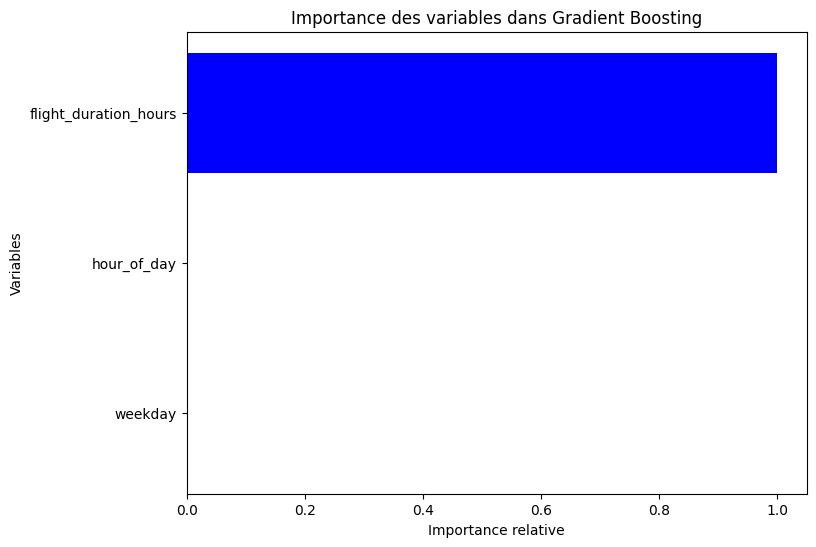

In [15]:
# ETAPE 4

import matplotlib.pyplot as plt

# Récupérer l'importance des variables dans le modèle Gradient Boosting ajusté
importances = gb_model.feature_importances_
feature_names = features.columns

# Créer un graphique pour visualiser l'importance des variables
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='blue')
plt.title('Importance des variables dans Gradient Boosting')
plt.xlabel('Importance relative')
plt.ylabel('Variables')
plt.show()


In [16]:
# Optimisation des hyperparametres

from sklearn.model_selection import GridSearchCV

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Créer le modèle Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Effectuer la recherche par grille
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Réentraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

# Prédire avec le modèle optimisé
y_pred_best = best_model.predict(X_test)

# Évaluer les performances du modèle optimisé
print("\nExactitude du modèle optimisé : ", accuracy_score(y_test, y_pred_best))
print("\nRapport de classification pour le modèle optimisé :")
print(classification_report(y_test, y_pred_best))


Meilleurs hyperparamètres :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Exactitude du modèle optimisé :  1.0

Rapport de classification pour le modèle optimisé :
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       229
        True       1.00      1.00      1.00       156

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385



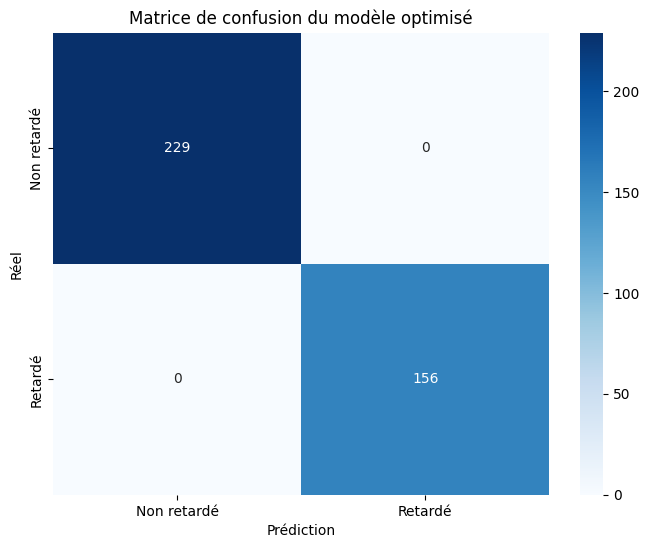

In [17]:
#PPRESENTATION DES RESULTATS

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non retardé', 'Retardé'], yticklabels=['Non retardé', 'Retardé'])
plt.title('Matrice de confusion du modèle optimisé')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()


In [18]:
pip install seaborn


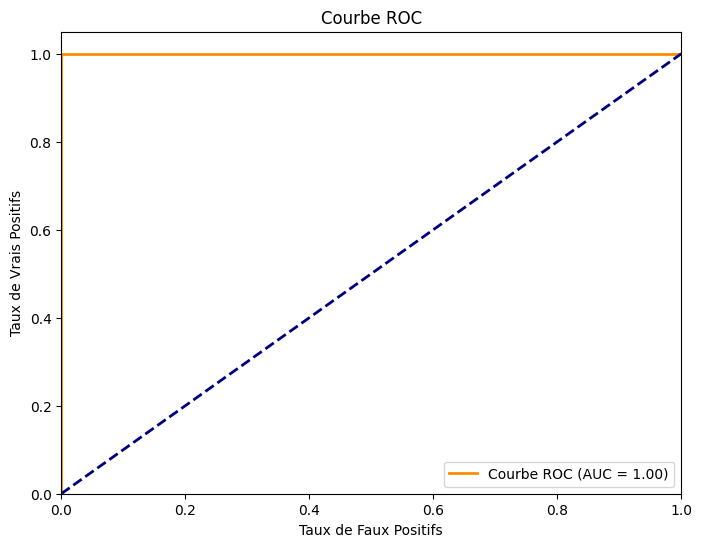

In [19]:
#Courbe ROC et AUC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédire les probabilités pour la classe "retardé"
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


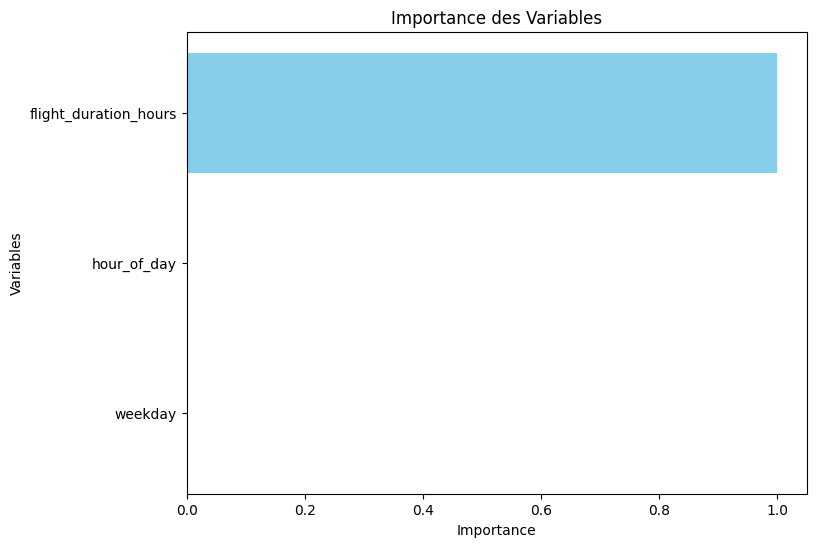

In [20]:
# Features importances 

importances = best_model.feature_importances_
feature_names = features.columns

# Tracer un graphique pour l'importance des variables
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.title("Importance des Variables")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()


In [21]:
#  TESTET LE STACKING 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Préparer les données
features = arrivals_df_clean[['weekday', 'hour_of_day', 'flight_duration_hours']]
target = arrivals_df_clean['delayed']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Entraîner un modèle de régression logistique
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Entraîner un modèle de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Entraîner un modèle Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [22]:
# Obtenir les prédictions pour chaque modèle sur les données de test
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Combiner les prédictions en un tableau pour le métamodèle
import numpy as np
X_meta = np.column_stack((lr_pred, rf_pred, gb_pred))


In [23]:
# Entraîner un métamodèle (régression logistique)
meta_model = LogisticRegression()
meta_model.fit(X_meta, y_test)

# Prédire avec le métamodèle
meta_pred = meta_model.predict(X_meta)

# Évaluer les performances du modèle d'ensemble
accuracy_meta = accuracy_score(y_test, meta_pred)
print(f"Exactitude du modèle d'ensemble (stacking) : {accuracy_meta}")

# Afficher le rapport de classification pour le modèle d'ensemble
print("\nRapport de classification pour le modèle d'ensemble :")
print(classification_report(y_test, meta_pred))


Exactitude du modèle d'ensemble (stacking) : 1.0

Rapport de classification pour le modèle d'ensemble :
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       229
        True       1.00      1.00      1.00       156

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385

